In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
df = pd.read_csv('BTC-USD.csv')
df.reset_index(drop=True, inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2742,2022-03-21,41246.132813,41454.410156,40668.042969,41077.996094,41077.996094,24615543271
2743,2022-03-22,41074.105469,43124.707031,40948.281250,42358.808594,42358.808594,32004652376
2744,2022-03-23,42364.378906,42893.507813,41877.507813,42892.957031,42892.957031,25242943069
2745,2022-03-24,42886.652344,44131.855469,42726.164063,43960.933594,43960.933594,31042992291


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2747 non-null   object 
 1   Open       2747 non-null   float64
 2   High       2747 non-null   float64
 3   Low        2747 non-null   float64
 4   Close      2747 non-null   float64
 5   Adj Close  2747 non-null   float64
 6   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.4+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2.747000e+03
mean,11668.600272,11981.034949,11325.596907,11682.892098,11682.892098,1.484704e+10
std,16323.683853,16759.568657,15825.584507,16330.191582,16330.191582,1.994819e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,609.122009,611.894501,606.309479,609.234009,609.234009,8.161285e+07
50%,6371.850098,6500.870117,6285.629883,6376.709961,6376.709961,5.227550e+09
75%,10728.271485,10992.468751,10412.890137,10755.395019,10755.395019,2.500517e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [7]:
df.duplicated().sum()

0

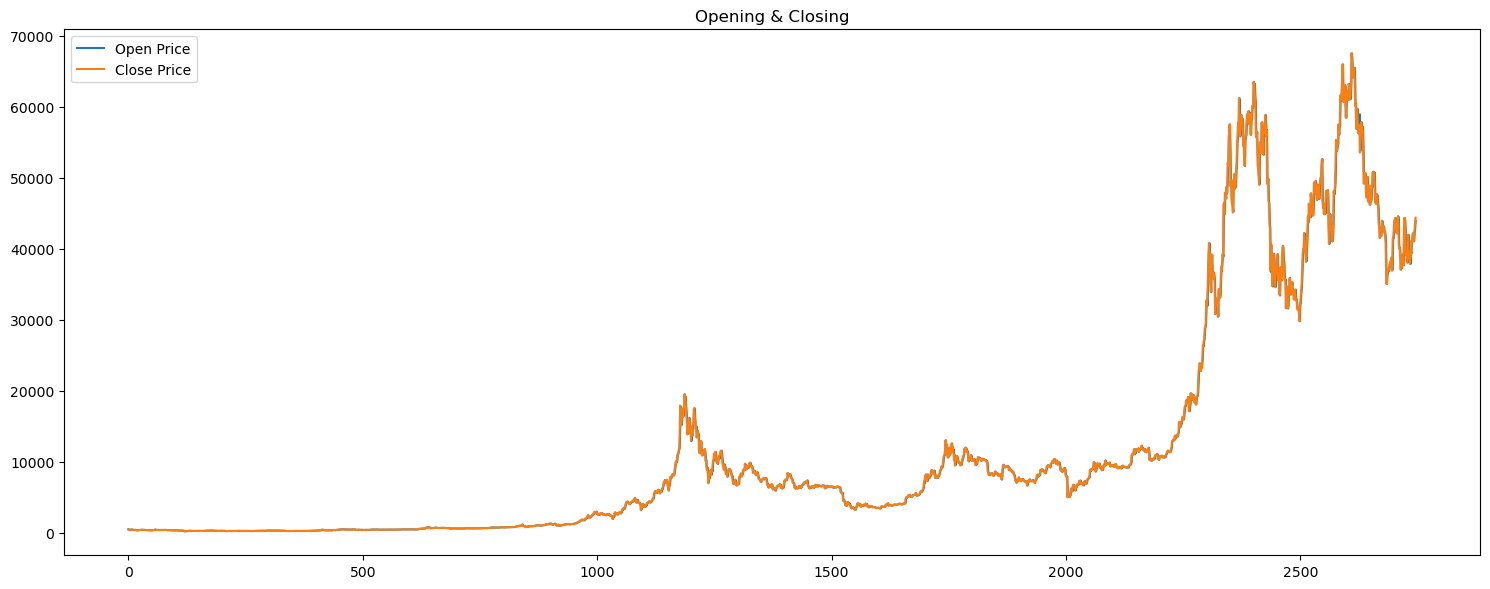

In [8]:
plt.figure(figsize=(15,6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title('Opening & Closing')
plt.legend(['Open Price','Close Price'])
plt.tight_layout()
plt.show()

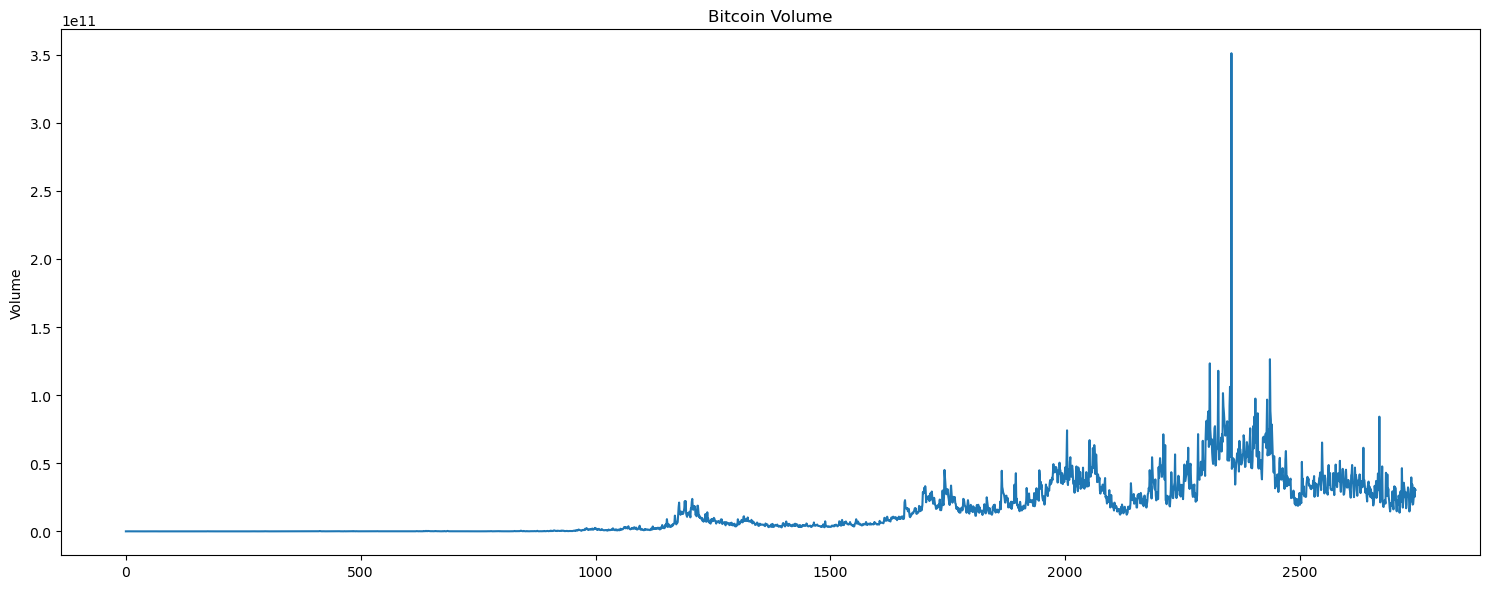

In [9]:
plt.figure(figsize=(15,6))
df['Volume'].plot()
plt.xlabel(None)
plt.ylabel('Volume')
plt.title('Bitcoin Volume')
plt.tight_layout()
plt.show()

In [10]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)
data = dataset.values
data.shape

(2747, 1)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df.Close.values.reshape(-1,1))

MinMaxScaler()

In [12]:
test_size = df[df['Date'] >= '2021-01-01'].shape[0]
train_size =df.shape[0] - test_size
print("Train Size :",train_size,"\nTest Size :",test_size)

Train Size : 2298 
Test Size : 449


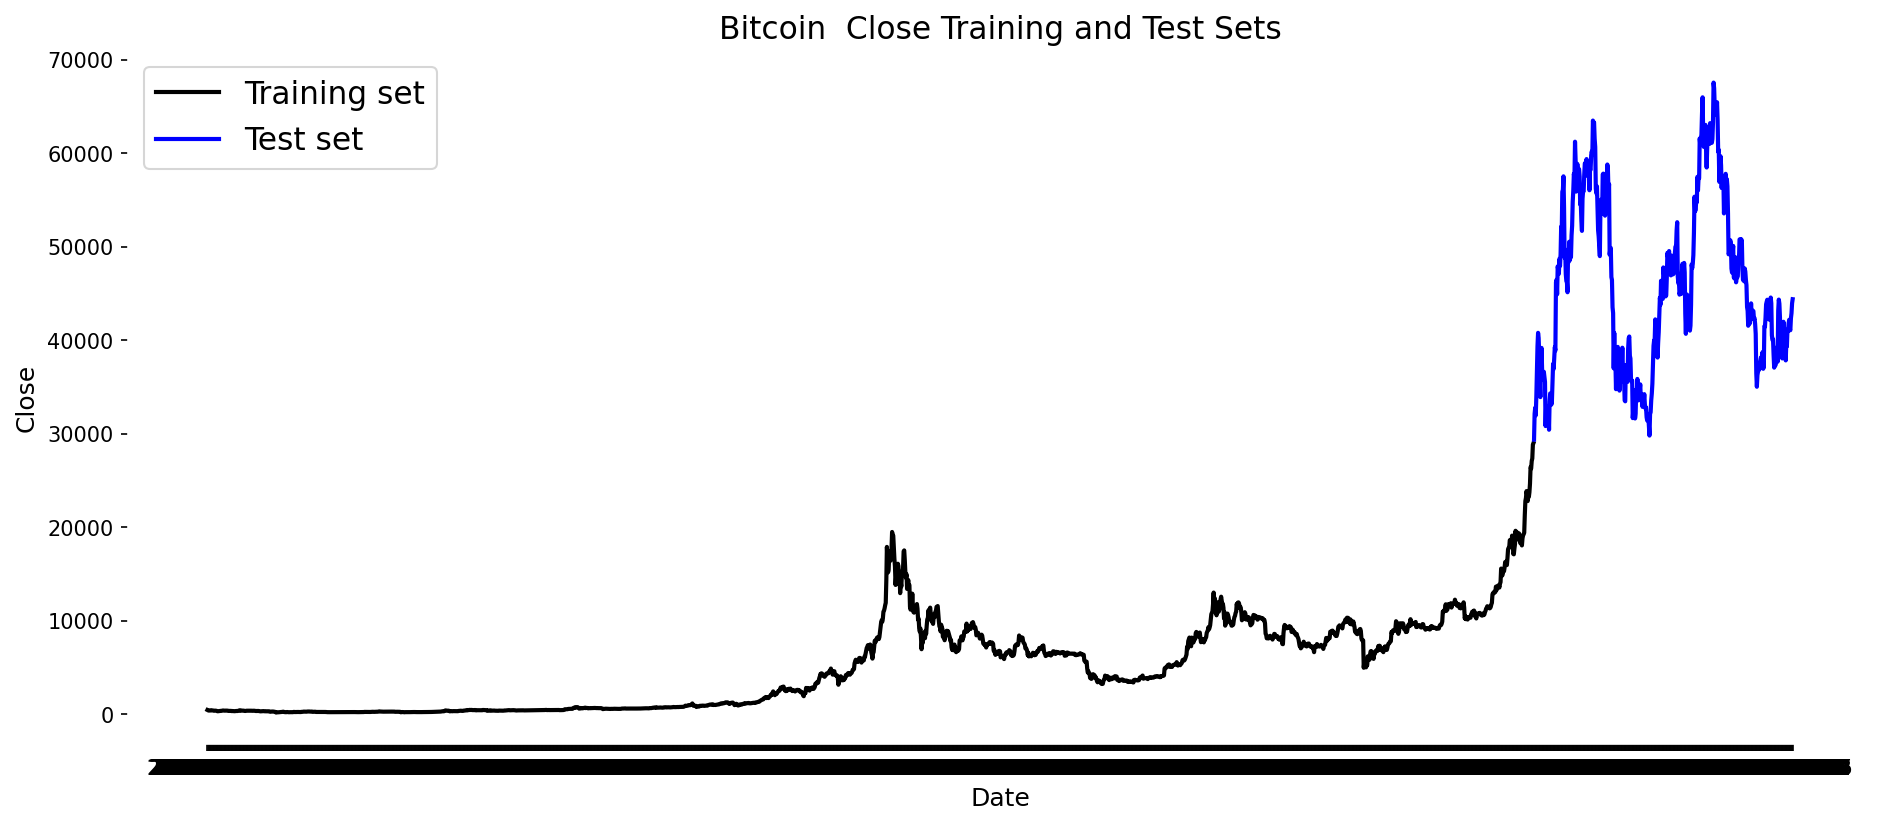

In [13]:
plt.figure(figsize=(15,6), dpi=150)
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='blue', lw=2)
plt.title('Bitcoin  Close Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.show()

In [14]:
window_size = 60

In [15]:
train_data = df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [16]:
test_data = df.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [17]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [19]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2238, 60, 1)
y_train Shape:  (2238, 1)
X_test Shape:   (449, 60, 1)
y_test Shape:   (449, 1)


In [20]:
from keras.models import Sequential
from keras.layers import Dropout 
from keras.optimizers import Adam
n_cols=1
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (X_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])
model.summary()

2025-06-04 13:49:05.324958: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-04 13:49:05.324994: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-04 13:49:05.325000: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-04 13:49:05.325262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-04 13:49:05.325271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/bibhanshuraj/tensorflow/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100


2025-06-04 13:49:06.000216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0015 - mean_absolute_error: 0.0249 - val_loss: 4.1585e-04 - val_mean_absolute_error: 0.0138
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.8223e-05 - mean_absolute_error: 0.0057 - val_loss: 5.0021e-04 - val_mean_absolute_error: 0.0159
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.9053e-05 - mean_absolute_error: 0.0055 - val_loss: 3.3883e-04 - val_mean_absolute_error: 0.0114
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.2234e-05 - mean_absolute_error: 0.0052 - val_loss: 3.5410e-04 - val_mean_absolute_error: 0.0126
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.0899e-05 - mean_absolute_error: 0.0047 - val_loss: 2.2330e-04 - val_mean_absolute_error: 0.0090
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.9213e-05 - mean_absolute_error: 0.0049 - val_loss: 1.8646e-04 - val_mean_absolute_error: 0.0085
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.5082e-

In [22]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - mean_absolute_error: 0.0469
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [23]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: [0.003118144581094384, 0.04755254089832306]
Test MAPE: 0.06724812472299614
Test Accuracy: 0.9327518752770039


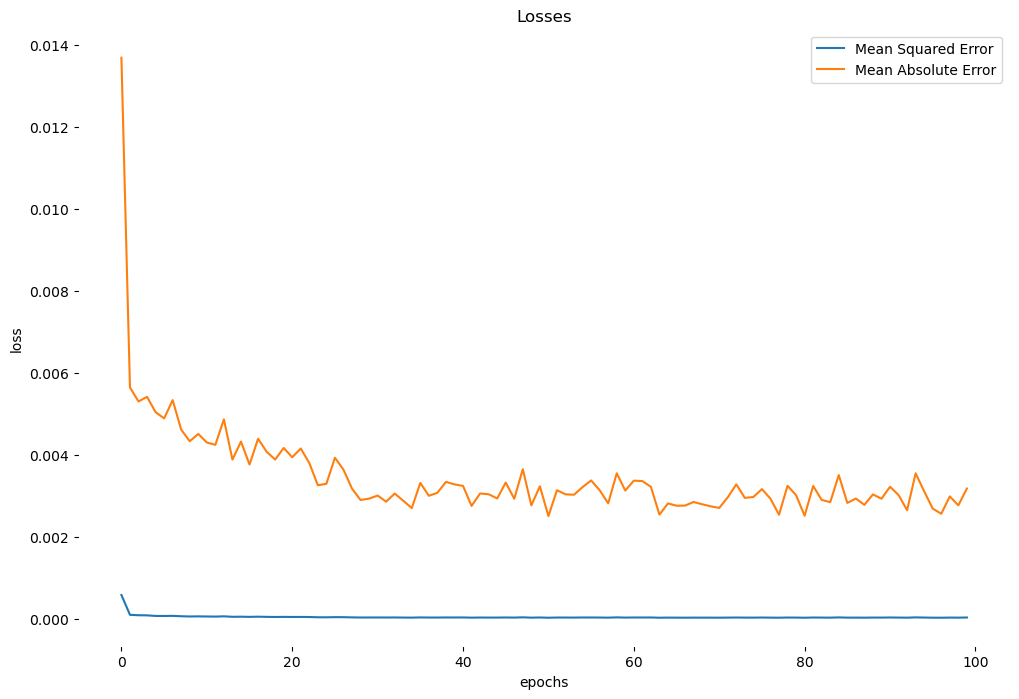

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [25]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

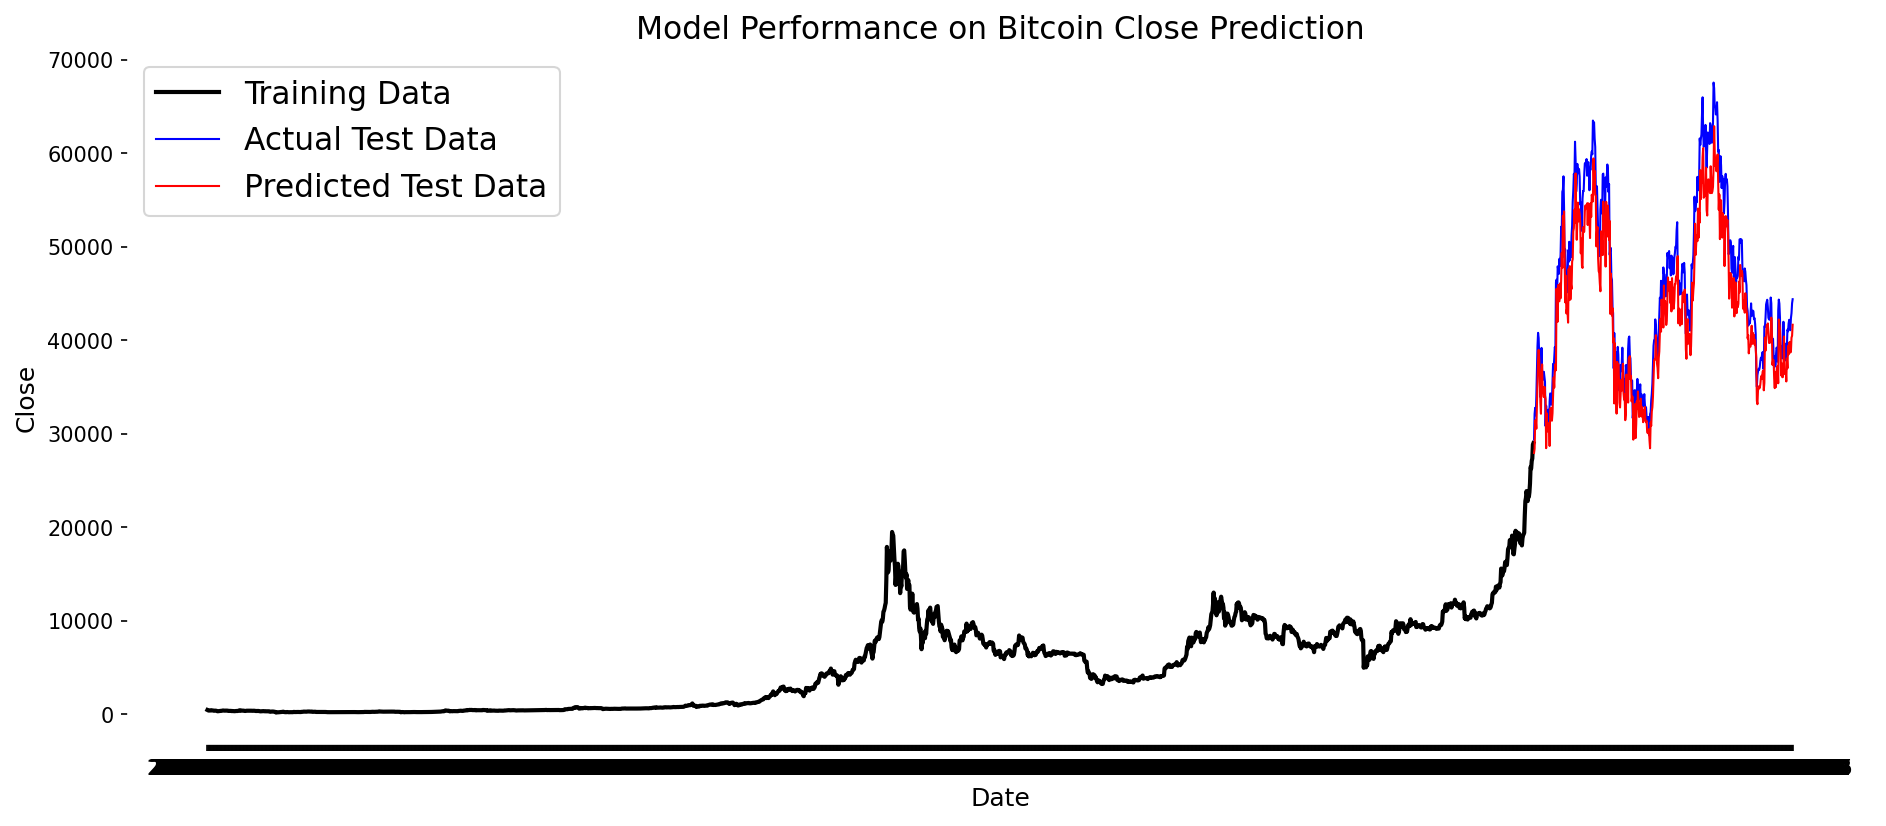

In [26]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'White'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=1)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=1)
plt.title('Model Performance on Bitcoin Close Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [27]:
predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [28]:
predictions = scaler.inverse_transform(predictions)
predictions.shape

(449, 1)

In [29]:
y_test = scaler.inverse_transform(y_test)

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

3080.4

In [30]:
preds_acts = pd.DataFrame(data={"Date":df['Date'].iloc[-test_size:] , 'Predictions':predictions.flatten(), 'Actuals':y_test.flatten() , })
preds_acts

,Date,Predictions,Actuals
2298,2021-01-01,27950.126953,29374.152344
2299,2021-01-02,28399.869141,32127.267578
2300,2021-01-03,31381.826172,32782.023438
2301,2021-01-04,31478.556641,31971.914063
2302,2021-01-05,30541.021484,33992.429688
...,...,...,...
2742,2022-03-21,38686.656250,41077.996094
2743,2022-03-22,38813.289062,42358.808594
2744,2022-03-23,40284.593750,42892.957031
2745,2022-03-24,40482.316406,43960.933594


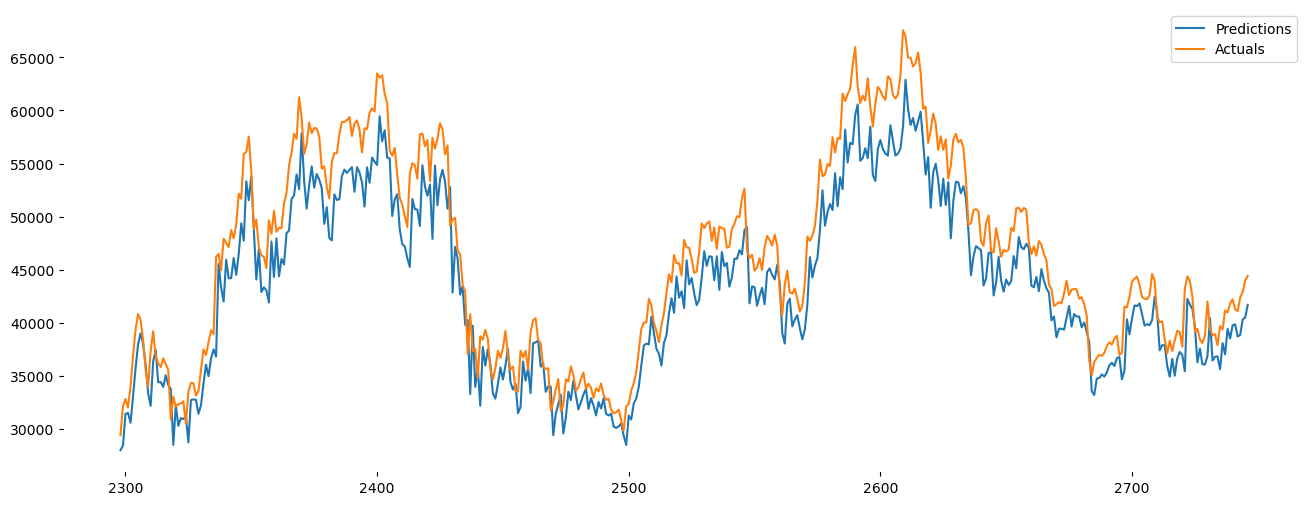

In [31]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()